# 520 Final Project - Fraud Data Detection

Mengtian Li, Zihan Zhou, Yizhen Wang, Songyu Yan

---

## Project Overview 
As the COVID-19 pandemic prevails, concerns over credit card fraud have worsened. As the U.S. Department of Commerce states, in the past quarantine era, 16 to 17\% of all shopping is completed via online transaction, which gives the scammers an incredible opportunity for financial information theft. A 27\% increase in total number of reported credit card fraud compared to the beginning of the yeas has been recorded. Our project aims to generate a data-based solution to prevent financial losses from both the card service company and customers. 

The [datasets](https://www.kaggle.com/mlg-ulb/creditcardfraud) contains transactions made by credit cards in September 2013 by european cardholders.
This dataset presents transactions that occurred in two days, where we have 492 frauds out of 284,807 transactions. The dataset is highly unbalanced, the positive class (frauds) account for 0.172% of all transactions.

---

## Importing Modules and Data

In [ ]:
!sudo apt-get install build-essential swig
!curl https://raw.githubusercontent.com/automl/auto-sklearn/master/requirements.txt | xargs -n 1 -L 1 pip install
!pip install auto-sklearn==0.10.0

Reading package lists... Done
Building dependency tree       
Reading state information... Done
build-essential is already the newest version (12.4ubuntu1).
Suggested packages:
  swig-doc swig-examples swig3.0-examples swig3.0-doc
The following NEW packages will be installed:
  swig swig3.0
0 upgraded, 2 newly installed, 0 to remove and 14 not upgraded.
Need to get 1,100 kB of archives.
After this operation, 5,822 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 swig3.0 amd64 3.0.12-1 [1,094 kB]
Get:2 http://archive.ubuntu.com/ubuntu bionic/universe amd64 swig amd64 3.0.12-1 [6,460 B]
Fetched 1,100 kB in 1s (1,453 kB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 76, <> line 2.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (T

In [ ]:
# data processing
import numpy as np
import pandas as pd
pd.options.display.max_columns = None
from sklearn.utils import class_weight

# visualizations
import seaborn as sns
import matplotlib.pyplot as pyplt
%matplotlib inline
from sklearn.metrics import plot_confusion_matrix

# statistics and modeling
from sklearn.metrics import precision_recall_curve, auc, roc_auc_score, fbeta_score, make_scorer, f1_score, jaccard_score
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE
from xgboost import XGBClassifier
import autosklearn.classification
import autosklearn.metrics

# sampling
from imblearn.over_sampling import SMOTE, RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from sklearn.model_selection import train_test_split

RANDOM_STATE = 10

import warnings
warnings.simplefilter("ignore")

/usr/local/lib/python3.6/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


In [ ]:
from google_drive_downloader import GoogleDriveDownloader as gdd

gdd.download_file_from_google_drive(file_id='1JY8LtZYus4p_ErebV2rp-M_7zMDnZM4W',
                                    dest_path='/content/creditcard.csv')

In [ ]:
# FILE_SOURCE = "/content/drive/MyDrive/creditcard.csv"

FILE_SOURCE = 'creditcard.csv'

raw_data = pd.read_csv(FILE_SOURCE)

In [ ]:
raw_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
Time      284807 non-null float64
V1        284807 non-null float64
V2        284807 non-null float64
V3        284807 non-null float64
V4        284807 non-null float64
V5        284807 non-null float64
V6        284807 non-null float64
V7        284807 non-null float64
V8        284807 non-null float64
V9        284807 non-null float64
V10       284807 non-null float64
V11       284807 non-null float64
V12       284807 non-null float64
V13       284807 non-null float64
V14       284807 non-null float64
V15       284807 non-null float64
V16       284807 non-null float64
V17       284807 non-null float64
V18       284807 non-null float64
V19       284807 non-null float64
V20       284807 non-null float64
V21       284807 non-null float64
V22       284807 non-null float64
V23       284807 non-null float64
V24       284807 non-null float64
V25       284807 non-null float64
V26  

The original dataset has <b> 0 </b> missing values. 


In [ ]:
raw_data.isnull().sum(axis=0)/len(raw_data)

INFO:numexpr.utils:NumExpr defaulting to 2 threads.


Time      0.0
V1        0.0
V2        0.0
V3        0.0
V4        0.0
V5        0.0
V6        0.0
V7        0.0
V8        0.0
V9        0.0
V10       0.0
V11       0.0
V12       0.0
V13       0.0
V14       0.0
V15       0.0
V16       0.0
V17       0.0
V18       0.0
V19       0.0
V20       0.0
V21       0.0
V22       0.0
V23       0.0
V24       0.0
V25       0.0
V26       0.0
V27       0.0
V28       0.0
Amount    0.0
Class     0.0
dtype: float64

---

## Data Interpretation and EDA
For customer privacy protection purposes, the given data contains only numerical input variables which are the result of a PCA transformation. Only 3 columns with numerical meanings are: 'Time', 'Amount', 'Class', explained below:

|Column Name | Interpretation|
|:-----------:|:---|
|Time| Number of seconds elapsed between this transaction and the first transaction in the dataset|
|Amount| Transaction amount, unifomr measurement unit|
| Class| 1 for fraudulent transactions, 0 otherwise

In [ ]:
# Find proportion of non-fraudulent transactions
1 - raw_data.Class.sum()/len(raw_data)

0.9982725143693799

99% not fraud, less than 1% fraud

### Transaction Amount Distribution Plot



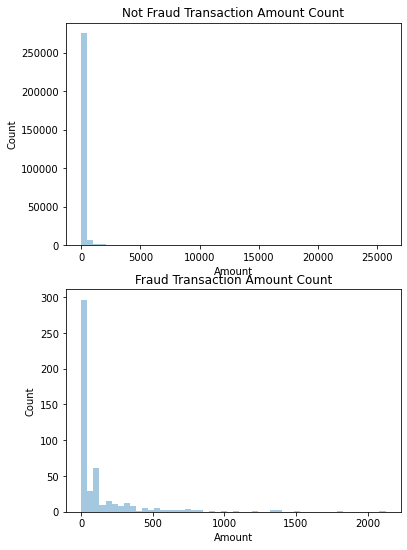

In [ ]:
fig, (ax0, ax1)= pyplt.subplots(2, 1, figsize=(6, 9))

sns.distplot(raw_data[raw_data.Class==0]['Amount'], kde=False, ax=ax0)
ax0.title.set_text('Not Fraud Transaction Amount Count')
ax0.yaxis.set_label_text('Count')

sns.distplot(raw_data[raw_data.Class==1]['Amount'], kde=False, ax=ax1)
ax1.title.set_text('Fraud Transaction Amount Count')
ax1.yaxis.set_label_text('Count')

fig.show()

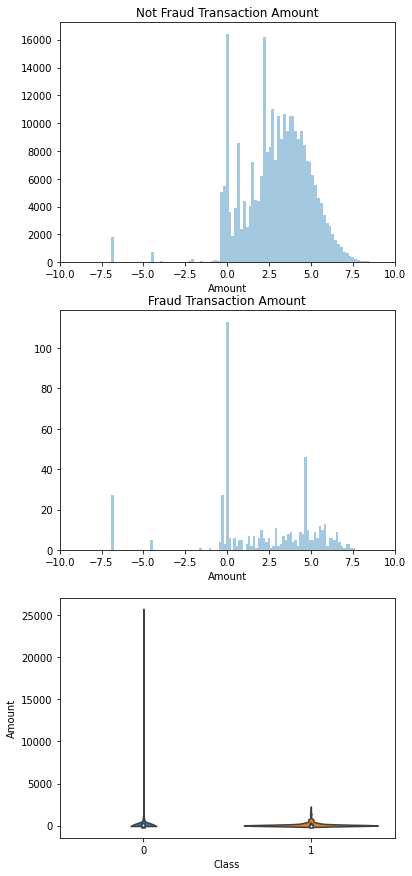

In [ ]:
fig, (ax0, ax1, ax2)= pyplt.subplots(3, 1, figsize=(6, 15))

sns.distplot(np.log(raw_data[raw_data.Class==0]['Amount']+0.001), bins=100, kde=False, ax=ax0)
ax0.title.set_text('Not Fraud Transaction Amount')
ax0.set_xlim(-10, 10)

sns.distplot(np.log(raw_data[raw_data.Class==1]['Amount']+0.001), bins=100, kde=False, ax=ax1)
ax1.title.set_text('Fraud Transaction Amount')
ax1.set_xlim(-10, 10)

sns.violinplot(x='Class', y='Amount', data=raw_data, showfliers=False, ax=ax2)
#ax2.title.set_text('Transaction Amount')

fig.show()

From graphs above, we can observe that all transactions are heavily left skewed, while non-fraudulent transactions have more large amount outliers. Fraudulent data has smaller quantiles and median.

### <b>Time</b> Visualization and Feature Engineering

Plotting raw values from <b>Time</b> gives an almost linear trend. This is reasonable as <b>Time</b> measures seconds elapsed after the first transactions, measured within 2 days. The sudden steep slope in time = \[150000,160000\] could be explained as decrease in transaction frequencies in midnight.

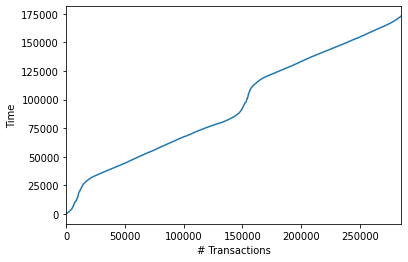

In [ ]:
raw_data.Time.plot()
pyplt.xlabel("# Transactions")
pyplt.ylabel("Time")
pyplt.show()

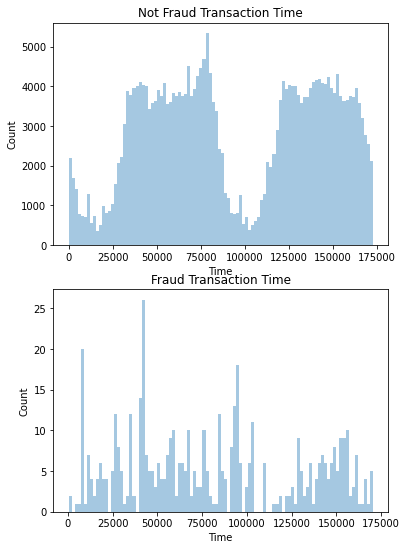

In [ ]:
fig, (ax0, ax1)= pyplt.subplots(2, 1, figsize=(6, 9))

sns.distplot(raw_data[raw_data.Class==0]['Time'], bins=100, kde=False, ax=ax0)
ax0.title.set_text('Not Fraud Transaction Time')
ax0.yaxis.set_label_text('Count')

sns.distplot(raw_data[raw_data.Class==1]['Time'], bins=100, kde=False, ax=ax1)
ax1.title.set_text('Fraud Transaction Time')
ax1.yaxis.set_label_text('Count')

fig.show()

As time alone measured in seconds may not be constructive for subsequent modeling. We binned timestamp into hour of a day to capture potential fraudulent transaction pattern within a 24-hour cycle.

In [ ]:
# Bin time into 24 hour classes
raw_data['Time'] = (raw_data['Time']/3600) % 24

### Correlation Heat Map

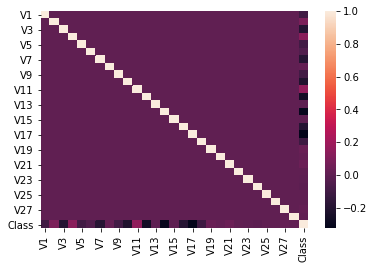

In [ ]:
corrMatrix = raw_data.drop(labels=['Time','Amount'],axis=1).corr()
sns.heatmap(corrMatrix)
pyplt.show()

All features other than 'Time' and 'Amount' are uncorrelated. This is reasonable as the given data has been projected after PCA, thus all features other than 'Time', 'Amount' and 'Class' are orthogonal.

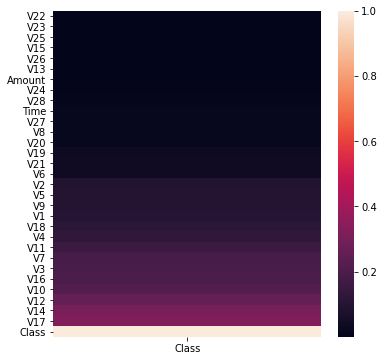

In [ ]:
pyplt.figure(figsize=(6,6))
corrMatrix = raw_data.corr()[['Class']]
corrMatrix = np.absolute(corrMatrix).sort_values('Class')
sns.heatmap(corrMatrix, annot=False)
pyplt.show()

In [ ]:
corrMatrix = raw_data.corr()[['Class']]
corrMatrix.sort_values('Class')

,Class
V17,-0.326481
V14,-0.302544
V12,-0.260593
V10,-0.216883
V16,-0.196539
V3,-0.192961
V7,-0.187257
V18,-0.111485
V1,-0.101347
V9,-0.097733


Feature V17, V14, V12 are top 3 most highly correlated features with 'Class' label.

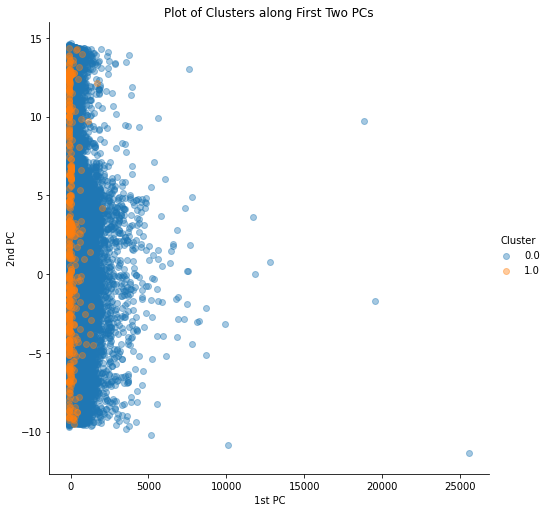

In [ ]:
pca = PCA(n_components=2)
raw_data_pca = pca.fit_transform(raw_data.drop(labels='Class',axis=1))

plotting_data = np.vstack((raw_data_pca.T, raw_data.Class)).T
plotting_df = pd.DataFrame(plotting_data, columns=['1st PC', '2nd PC', 'Cluster'])

sns.FacetGrid(plotting_df, hue='Cluster',height=7).map(pyplt.scatter, '1st PC', '2nd PC',alpha=0.4).add_legend()
pyplt.title('Plot of Clusters along First Two PCs')
pyplt.show()

In [ ]:
df = raw_data[raw_data.Class == 1]
df = pd.concat([df, raw_data[raw_data.Class == 0]], axis = 0)

# Scale features
standard_scaler = StandardScaler()
df_std = standard_scaler.fit_transform(df)
y = df.ix[:,-1].values

tsne = TSNE(n_components=2, random_state=0)
x_test_2d = tsne.fit_transform(df_std)

# Build the t_SNE projected scatter plot
color_map = {0:'red', 1:'blue'}
pyplt.figure()
for idx, cl in enumerate(np.unique(y)):
    pyplt.scatter(x = x_test_2d[y==cl,0], 
                y = x_test_2d[y==cl,1], 
                c = color_map[idx], 
                label = cl, s=5)
pyplt.xlabel('X in t-SNE')
pyplt.ylabel('Y in t-SNE')
pyplt.legend(loc='upper left')
pyplt.title('t-SNE visualization of test data')
pyplt.show()

# Due to colab running, graph is saved in local jupyter notebook

---
## Modeling and Imbalanced Data Handling
We adopted 3 methods for handling imbalanced data:


*   Change of measurement metrics. Instead of measuring models using accuracy, we used f1-score, precision-recall-auc instead.
*   Random sampling and synthetic data generation
*   scikit-learn built in class-weight adjustments.

We trained following models and compared their performance:


*   Baseline Model: [SVM](https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html?highlight=svc#sklearn.svm.SVC)
*   [Random Forest](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html)
*   [Gradient Boosting](https://xgboost.readthedocs.io/en/latest/)
*   [AutoML](https://pypi.org/project/automl/)



### Train Test Split

In [ ]:
y = raw_data.Class 
X = raw_data.drop(labels='Class', axis=1)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_STATE, shuffle=True)

In [ ]:
print("X_train shape is.{}".format(X_train.shape))
print("y_train shape is.{}".format(y_train.shape))
print("X_test shape is.{}".format(X_test.shape))
print("y_test shape is.{}".format(y_test.shape))

X_train shape is.(227845, 30)
y_train shape is.(227845,)
X_test shape is.(56962, 30)
y_test shape is.(56962,)


### Model Training Pipeline
Takes a sampling method and scikit-learn model type, returns list performance evaluation metrics and plots confusion matrix.

In [ ]:
# Machine learning training pipeline
def model_pipeline(X_train, y_train, X_test, y_test, model, sampler=None):
    '''
    Building up model pipelines with weighted classes
    
    X_train: training features with size (n_1,p)
    y_train: training labels with size (n_1,1)
    X_test: testing features with size (n_2, p)
    y_test: testing labels with size (n_2, p)
    
    model: estimator
    sampler: sampling method, None by default
    
    return: dictionary of performance metrics
    '''
    if sampler:
        #resample X_train, y_train
        X_train, y_train = sampler.fit_sample(X_train, y_train)
    
    model.fit(X_train, y_train)
    predictions = model.predict(X_test)

    accuracy = metrics.accuracy_score(y_test, predictions)
    precision, recall, threshold = metrics.precision_recall_curve(y_test, predictions)
    f1score = fbeta_score(y_test, predictions, beta=1.0)
    fscore = fbeta_score(y_test, predictions, beta=0.5)
    tn, fp, fn, tp = metrics.confusion_matrix(y_test, predictions).ravel()
    roc_auc = roc_auc_score(y_test, predictions)
    precision_recall_auc = auc(recall, precision)
    jaccard = jaccard_score(y_test, predictions)
            
    #plot_confusion matrix
    title = type(model).__name__
    if sampler:
        title += type(sampler).__name__
    disp = plot_confusion_matrix(model, X_test, y_test)                     
    disp.ax_.set_title(title)
    
    performance = {'model':type(model).__name__, 'accuracy': accuracy,
                   'precision': precision, 'recall': recall, 'threshold':threshold,
                   'f1score': f1score, 'fscore':fscore,
                   'tp': tp, 'tn': tn, 'fp': fp, 'fn': fn,
                   'roc_auc': roc_auc, 'precision_recall_auc': precision_recall_auc,
                   'jaccard': jaccard}
    return performance

In [ ]:
# imblearn Sampler Initialization
under_sampler = RandomUnderSampler()
over_sampler = RandomOverSampler()
SMOTE_sampler = SMOTE()

## Base Model

### Logistic Regression

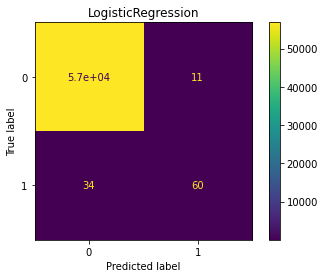

In [ ]:
model_logistic = LogisticRegression()
performance_logistic = model_pipeline(X_train, y_train, X_test, y_test, model_logistic)

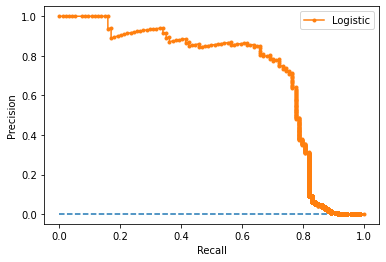

In [ ]:
model_logistic.fit(X_train, y_train)
yhat = model_logistic.predict_proba(X_test)
# retrieve just the probabilities for the positive class
pos_probs = yhat[:, 1]
# plot no skill roc curve
no_skill = len(y[y==1]) / len(y)
pyplt.plot([0, 1], [no_skill, no_skill], linestyle='--')
# calculate roc curve for model
precision, recall, _ = precision_recall_curve(y_test, pos_probs)
# plot the model precision-recall curve
pyplt.plot(recall, precision, marker='.', label='Logistic')
# axis labels
pyplt.xlabel('Recall')
pyplt.ylabel('Precision')
# show the legend
pyplt.legend()
# show the plot
pyplt.show()

In [ ]:
performance_logistic

{'accuracy': 0.9992099996488887,
 'f1score': 0.7272727272727273,
 'fn': 34,
 'fp': 11,
 'fscore': 0.7936507936507936,
 'jaccard': 0.5714285714285714,
 'model': 'LogisticRegression',
 'precision': array([0.00165022, 0.84507042, 1.        ]),
 'precision_recall_auc': 0.7419825920149049,
 'recall': array([1.        , 0.63829787, 0.        ]),
 'roc_auc': 0.8190522209701002,
 'threshold': array([0, 1]),
 'tn': 56857,
 'tp': 60}

Balanced Weight

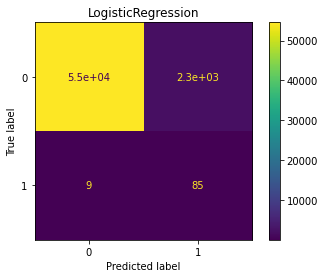

In [ ]:
model_logistic_balanced = LogisticRegression(random_state=0, class_weight='balanced')
performance_logistic_balanced = model_pipeline(X_train, y_train, X_test, y_test, model_logistic_balanced)

In [ ]:
performance_logistic_balanced

{'accuracy': 0.9597450932200414,
 'f1score': 0.06902151847340642,
 'fn': 9,
 'fp': 2284,
 'fscore': 0.04440961337513062,
 'jaccard': 0.03574432296047098,
 'model': 'LogisticRegression',
 'precision': array([0.00165022, 0.03588012, 1.        ]),
 'precision_recall_auc': 0.4701467187062445,
 'recall': array([1.        , 0.90425532, 0.        ]),
 'roc_auc': 0.9320460671147368,
 'threshold': array([0, 1]),
 'tn': 54584,
 'tp': 85}

Logistic Over / Under / SMOTE Sampling

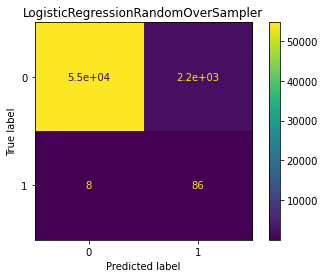

In [ ]:
performance_logistic_over = model_pipeline(X_train, y_train, X_test, y_test, model_logistic, over_sampler)

In [ ]:
performance_logistic_over

{'accuracy': 0.961939538639795,
 'f1score': 0.07350427350427349,
 'fn': 8,
 'fp': 2160,
 'fscore': 0.047367261511346105,
 'jaccard': 0.038154392191659274,
 'model': 'LogisticRegression',
 'precision': array([0.00165022, 0.03829029, 1.        ]),
 'precision_recall_auc': 0.47666217769194213,
 'recall': array([1.        , 0.91489362, 0.        ]),
 'roc_auc': 0.9384554601249029,
 'threshold': array([0, 1]),
 'tn': 54708,
 'tp': 86}

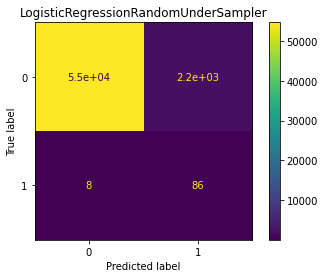

In [ ]:
performance_logistic_under = model_pipeline(X_train, y_train, X_test, y_test, model_logistic, under_sampler)

In [ ]:
performance_logistic_under

{'accuracy': 0.961974649766511,
 'f1score': 0.07356715141146279,
 'fn': 8,
 'fp': 2158,
 'fscore': 0.0474090407938258,
 'jaccard': 0.03818827708703375,
 'model': 'LogisticRegression',
 'precision': array([0.00165022, 0.03832442, 1.        ]),
 'precision_recall_auc': 0.47667924110275134,
 'recall': array([1.        , 0.91489362, 0.        ]),
 'roc_auc': 0.9384730447067415,
 'threshold': array([0, 1]),
 'tn': 54710,
 'tp': 86}

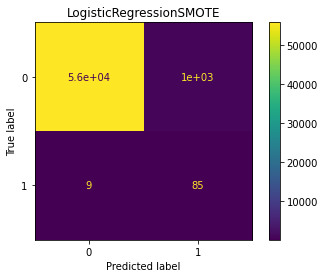

In [ ]:
performance_logistic_SMOTE = model_pipeline(X_train, y_train, X_test, y_test, model_logistic, SMOTE_sampler)

In [ ]:
performance_logistic_SMOTE

{'accuracy': 0.9816017696007865,
 'f1score': 0.1395730706075534,
 'fn': 9,
 'fp': 1039,
 'fscore': 0.0925925925925926,
 'jaccard': 0.07502206531332745,
 'model': 'LogisticRegression',
 'precision': array([0.00165022, 0.07562278, 1.        ]),
 'precision_recall_auc': 0.4900180475099351,
 'recall': array([1.        , 0.90425532, 0.        ]),
 'roc_auc': 0.9429924693092926,
 'threshold': array([0, 1]),
 'tn': 55829,
 'tp': 85}

### SVM


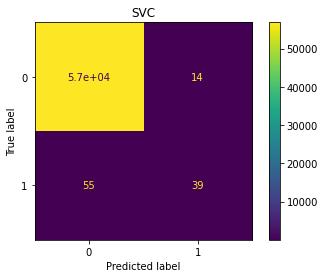

In [ ]:
model_svm = svm.SVC(kernel='linear', gamma='auto')
performance_svm = model_pipeline(X_train, y_train, X_test, y_test, model_svm)

In [ ]:
performance_svm

{'accuracy': 0.9987886661282961,
 'f1score': 0.5306122448979591,
 'fn': 55,
 'fp': 14,
 'fscore': 0.6372549019607843,
 'jaccard': 0.3611111111111111,
 'model': 'SVC',
 'precision': array([0.00165022, 0.73584906, 1.        ]),
 'precision_recall_auc': 0.5758541148048708,
 'recall': array([1.        , 0.41489362, 0.        ]),
 'roc_auc': 0.7073237164377677,
 'threshold': array([0, 1]),
 'tn': 56854,
 'tp': 39}

SVM with Balanced Class Weight

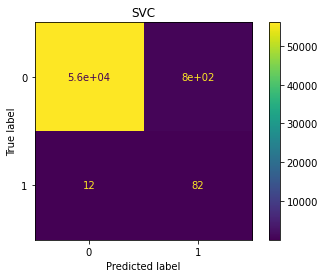

In [ ]:
model_svm_balanced = svm.SVC(kernel='linear', gamma='auto', class_weight='balanced')
performance_svm_balanced = model_pipeline(X_train, y_train, X_test, y_test, model_svm_balanced)

In [ ]:
performance_svm_balanced

{'accuracy': 0.9857448825532812,
 'f1score': 0.1680327868852459,
 'fn': 12,
 'fp': 800,
 'fscore': 0.11319712865819988,
 'jaccard': 0.09172259507829977,
 'model': 'SVC',
 'precision': array([0.00165022, 0.09297052, 1.        ]),
 'precision_recall_auc': 0.4827608069170807,
 'recall': array([1.        , 0.87234043, 0.        ]),
 'roc_auc': 0.9291363800304999,
 'threshold': array([0, 1]),
 'tn': 56068,
 'tp': 82}

SVM Over / Under / SMOTE Sampling

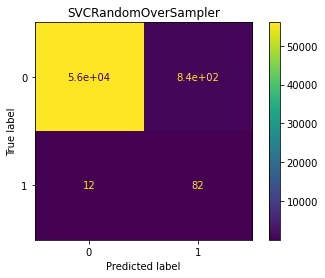

In [ ]:
performance_svm_over = model_pipeline(X_train, y_train, X_test, y_test, model_svm, over_sampler)

In [ ]:
performance_svm_over

{'accuracy': 0.985025104455602,
 'f1score': 0.16125860373647985,
 'fn': 12,
 'fp': 841,
 'fscore': 0.10829371368198627,
 'jaccard': 0.0877005347593583,
 'model': 'SVC',
 'precision': array([0.00165022, 0.08884074, 1.        ]),
 'precision_recall_auc': 0.48069591451013594,
 'recall': array([1.        , 0.87234043, 0.        ]),
 'roc_auc': 0.9287758961028076,
 'threshold': array([0, 1]),
 'tn': 56027,
 'tp': 82}

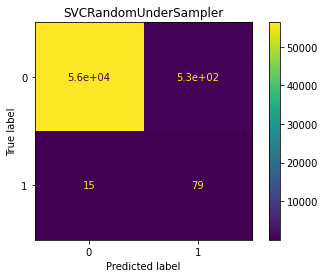

In [ ]:
performance_svm_under = model_pipeline(X_train, y_train, X_test, y_test, model_svm, under_sampler)

In [ ]:
performance_svm_under

{'accuracy': 0.9903795512798006,
 'f1score': 0.2237960339943343,
 'fn': 15,
 'fp': 533,
 'fscore': 0.15538945712037766,
 'jaccard': 0.12599681020733652,
 'model': 'SVC',
 'precision': array([0.00165022, 0.12908497, 1.        ]),
 'precision_recall_auc': 0.48488691634276276,
 'recall': array([1.        , 0.84042553, 0.        ]),
 'roc_auc': 0.9155264748974482,
 'threshold': array([0, 1]),
 'tn': 56335,
 'tp': 79}

In [ ]:
model_svm = svm.SVC(kernel='linear', gamma='auto')
performance_svm_SMOTE = model_pipeline(X_train, y_train, X_test, y_test, model_svm, SMOTE_sampler)
print(performance_svm_SMOTE)

### Random Forest

### Vanilla tree without imbalanced data handler

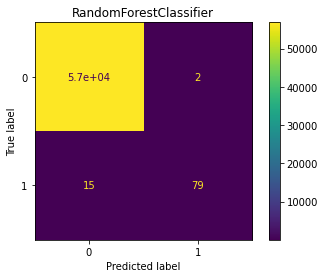

In [ ]:
model_RF_vanilla = RandomForestClassifier(n_estimators=100,random_state=RANDOM_STATE)
performance_RF = model_pipeline(X_train, y_train, X_test, y_test, model_RF_vanilla)

In [ ]:
performance_RF

{'accuracy': 0.9997015554229135,
 'f1score': 0.9028571428571429,
 'fn': 15,
 'fp': 2,
 'fscore': 0.9449760765550241,
 'jaccard': 0.8229166666666666,
 'model': 'RandomForestClassifier',
 'precision': array([0.00165022, 0.97530864, 1.        ]),
 'precision_recall_auc': 0.9079987536702864,
 'recall': array([1.        , 0.84042553, 0.        ]),
 'roc_auc': 0.9201951813756081,
 'threshold': array([0, 1]),
 'tn': 56866,
 'tp': 79}

#### Balanced Class Weight

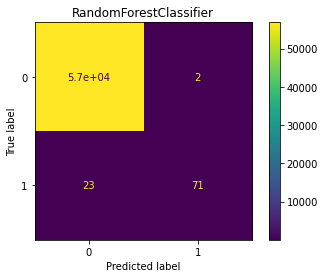

In [ ]:
model_RF1 = RandomForestClassifier(n_estimators=100,random_state=RANDOM_STATE, class_weight='balanced')
performance_RF_class_reweight = model_pipeline(X_train, y_train, X_test, y_test, model_RF1)

In [ ]:
performance_RF_class_reweight

{'accuracy': 0.9995611109160493,
 'f1score': 0.8502994011976047,
 'fn': 23,
 'fp': 2,
 'fscore': 0.9196891191709846,
 'jaccard': 0.7395833333333334,
 'model': 'RandomForestClassifier',
 'precision': array([0.00165022, 0.97260274, 1.        ]),
 'precision_recall_auc': 0.8641628333097161,
 'recall': array([1.        , 0.75531915, 0.        ]),
 'roc_auc': 0.8776419898862464,
 'threshold': array([0, 1]),
 'tn': 56866,
 'tp': 71}

#### Random Under/ Over/ SMOTE Sampling

In [ ]:
RF = RandomForestClassifier(n_estimators=100,random_state=RANDOM_STATE)

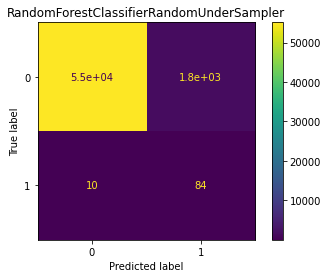

In [ ]:
performance_RF_under = model_pipeline(X_train, y_train, X_test, y_test, RF, under_sampler)

In [ ]:
performance_RF_under

{'accuracy': 0.9690670973631543,
 'f1score': 0.08704663212435233,
 'fn': 10,
 'fp': 1752,
 'fscore': 0.056466792148426995,
 'jaccard': 0.04550379198266522,
 'model': 'RandomForestClassifier',
 'precision': array([0.00165022, 0.04575163, 1.        ]),
 'precision_recall_auc': 0.4697721054485521,
 'recall': array([1.        , 0.89361702, 0.        ]),
 'roc_auc': 0.9314044169476459,
 'threshold': array([0, 1]),
 'tn': 55116,
 'tp': 84}

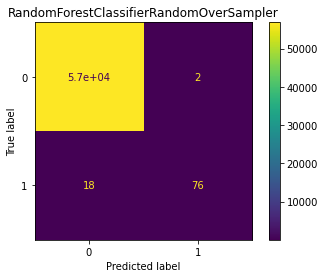

In [ ]:
performance_RF_over = model_pipeline(X_train, y_train, X_test, y_test, RF, over_sampler)

In [ ]:
performance_RF_over

{'accuracy': 0.9996488887328394,
 'f1score': 0.8837209302325582,
 'fn': 18,
 'fp': 2,
 'fscore': 0.9359605911330049,
 'jaccard': 0.7916666666666666,
 'model': 'RandomForestClassifier',
 'precision': array([0.00165022, 0.97435897, 1.        ]),
 'precision_recall_auc': 0.8915928063986456,
 'recall': array([1.        , 0.80851064, 0.        ]),
 'roc_auc': 0.9042377345670976,
 'threshold': array([0, 1]),
 'tn': 56866,
 'tp': 76}

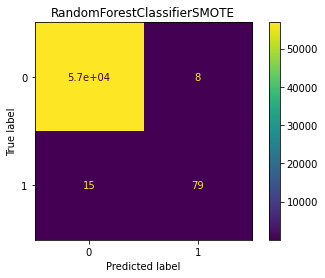

In [ ]:
performance_RF_over = model_pipeline(X_train, y_train, X_test, y_test, RF, SMOTE_sampler)

In [ ]:
performance_RF_over

{'accuracy': 0.9995962220427653,
 'f1score': 0.87292817679558,
 'fn': 15,
 'fp': 8,
 'fscore': 0.8936651583710407,
 'jaccard': 0.7745098039215687,
 'model': 'RandomForestClassifier',
 'precision': array([0.00165022, 0.90804598, 1.        ]),
 'precision_recall_auc': 0.8743674211883793,
 'recall': array([1.        , 0.84042553, 0.        ]),
 'roc_auc': 0.9201424276300922,
 'threshold': array([0, 1]),
 'tn': 56860,
 'tp': 79}

In [ ]:
# Parameter Grid for cross-validated grid-search
n_estimators = [100,500,700]
max_features = ['sqrt']
max_depth = [3, 5]
min_samples_split = [2, 5]
bootstrap = [True, False]

# Set up parameter grid
para_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'bootstrap': bootstrap}

Due to time limit, we performed random forest grid search in local notebooks and received following result:
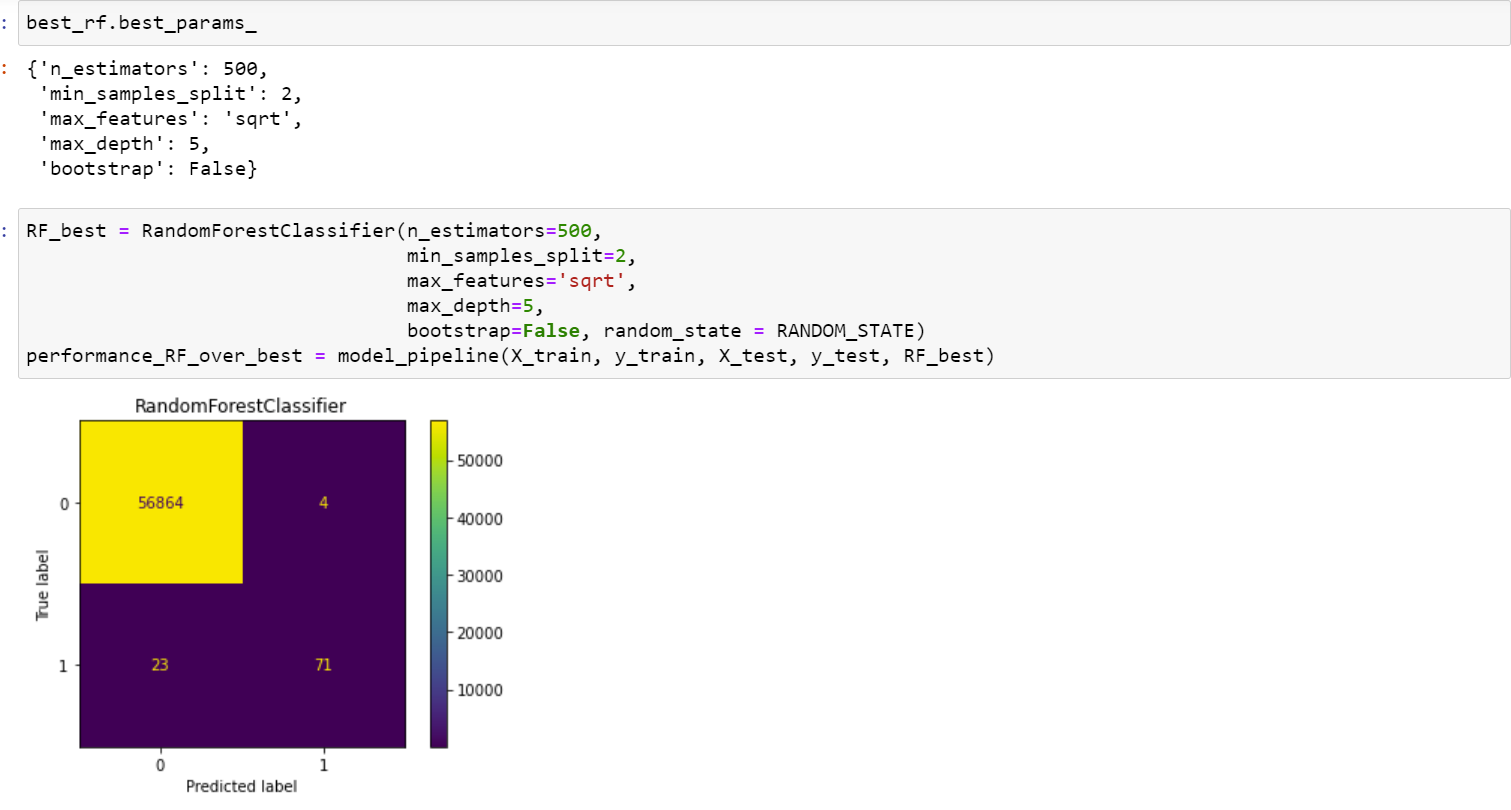

### XGBoost

In [ ]:
X_train_xgboost = np.array(X_train.values)
X_test_xgboost = np.array(X_test.values)

#### No balancing

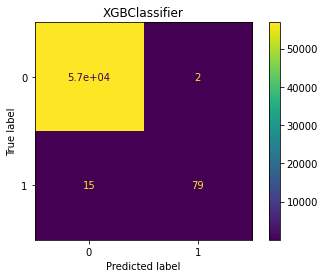

In [ ]:
xgboost_model = XGBClassifier(n_estimators=500, random_state=RANDOM_STATE, tree_method = "gpu_hist")
performance_xgboost_vanilla = model_pipeline(X_train, y_train, X_test, y_test, xgboost_model)

In [ ]:
performance_xgboost_vanilla

{'accuracy': 0.9997015554229135,
 'f1score': 0.9028571428571429,
 'fn': 15,
 'fp': 2,
 'fscore': 0.9449760765550241,
 'jaccard': 0.8229166666666666,
 'model': 'XGBClassifier',
 'precision': array([0.00165022, 0.97530864, 1.        ]),
 'precision_recall_auc': 0.9079987536702864,
 'recall': array([1.        , 0.84042553, 0.        ]),
 'roc_auc': 0.9201951813756081,
 'threshold': array([0, 1]),
 'tn': 56866,
 'tp': 79}

####Balanced Class Weight

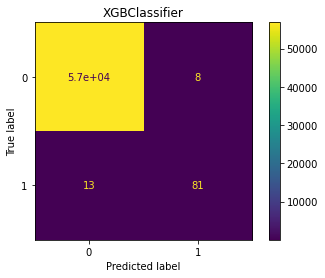

In [ ]:
xgboost_model = XGBClassifier(n_estimators=500, random_state=RANDOM_STATE, scale_pos_weight=99, tree_method = "gpu_hist")
performance_xgboost_balanced = model_pipeline(X_train, y_train, X_test, y_test, xgboost_model)

In [ ]:
performance_xgboost_balanced

{'accuracy': 0.9996313331694814,
 'f1score': 0.8852459016393442,
 'fn': 13,
 'fp': 8,
 'fscore': 0.9,
 'jaccard': 0.7941176470588235,
 'model': 'XGBClassifier',
 'precision': array([0.00165022, 0.91011236, 1.        ]),
 'precision_recall_auc': 0.8860213547668953,
 'recall': array([1.        , 0.86170213, 0.        ]),
 'roc_auc': 0.9307807255024326,
 'threshold': array([0, 1]),
 'tn': 56860,
 'tp': 81}

#### Random Under/ Over/ SMOTE Sampling

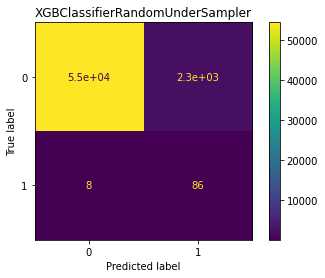

In [ ]:
xgboost_model = XGBClassifier(n_estimators=500, random_state=RANDOM_STATE, tree_method = "gpu_hist")
performance_xgboost_under = model_pipeline(X_train_xgboost, y_train, X_test_xgboost, y_test, xgboost_model, under_sampler)

In [ ]:
performance_xgboost_under

{'accuracy': 0.9587795372353499,
 'f1score': 0.06825396825396825,
 'fn': 8,
 'fp': 2340,
 'fscore': 0.0438865074505001,
 'jaccard': 0.03533278553820871,
 'model': 'XGBClassifier',
 'precision': array([0.00165022, 0.0354493 , 1.        ]),
 'precision_recall_auc': 0.4752416803930894,
 'recall': array([1.        , 0.91489362, 0.        ]),
 'roc_auc': 0.9368728477594249,
 'threshold': array([0, 1]),
 'tn': 54528,
 'tp': 86}

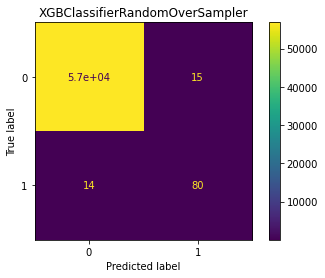

In [ ]:
performance_xgboost_over = model_pipeline(X_train_xgboost, y_train, X_test_xgboost, y_test, xgboost_model, over_sampler)

In [ ]:
performance_xgboost_over

{'accuracy': 0.9994908886626171,
 'f1score': 0.8465608465608466,
 'fn': 14,
 'fp': 15,
 'fscore': 0.8438818565400843,
 'jaccard': 0.7339449541284404,
 'model': 'XGBClassifier',
 'precision': array([0.00165022, 0.84210526, 1.        ]),
 'precision_recall_auc': 0.8467074354160706,
 'recall': array([1.        , 0.85106383, 0.        ]),
 'roc_auc': 0.9254000305298271,
 'threshold': array([0, 1]),
 'tn': 56853,
 'tp': 80}

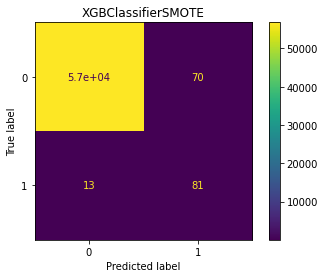

In [ ]:
performance_xgboost_SMOTE = model_pipeline(X_train_xgboost, y_train, X_test_xgboost, y_test, xgboost_model, SMOTE_sampler)

In [ ]:
performance_xgboost_SMOTE

{'accuracy': 0.9985428882412837,
 'f1score': 0.6612244897959183,
 'fn': 13,
 'fp': 70,
 'fscore': 0.5802292263610315,
 'jaccard': 0.49390243902439024,
 'model': 'XGBClassifier',
 'precision': array([0.00165022, 0.53642384, 1.        ]),
 'precision_recall_auc': 0.6991770955214156,
 'recall': array([1.        , 0.86170213, 0.        ]),
 'roc_auc': 0.9302356034654345,
 'threshold': array([0, 1]),
 'tn': 56798,
 'tp': 81}

In [ ]:

xgboost_model_cv = XGBClassifier(
    tree_method = "gpu_hist",
    random_state=RANDOM_STATE, 
    eval_metric="aucpr"
)
# Create the grid search parameter grid and scoring funcitons
param_grid = {
    "learning_rate": [0.1, 0.01],
    "colsample_bytree": [0.6, 0.8, 1.0],
    "subsample": [0.6, 0.8, 1.0],
    "max_depth": [2, 3, 4],
    "n_estimators": [500, 600, 700, 800],
    "reg_lambda": [1, 1.5, 2],
    "gamma": [0, 0.1, 0.3],
}
# create the Kfold object
num_folds = 5
kfold = StratifiedKFold(n_splits=num_folds, random_state=RANDOM_STATE)
# create the grid search object
n_iter=50
grid = RandomizedSearchCV(
    estimator=xgboost_model_cv, 
    param_distributions=param_grid,
    cv=kfold,
    scoring='f1',
    n_jobs=-1,
    n_iter=n_iter,
    refit="f1",
)
# fit grid search
best_model = grid.fit(X_train,y_train)
print(f'Best score: {best_model.best_score_}')
print(f'Best model: {best_model.best_params_}')

Best score: 0.8579109731542017
Best model: {'subsample': 0.8, 'reg_lambda': 1, 'n_estimators': 600, 'max_depth': 4, 'learning_rate': 0.1, 'gamma': 0.1, 'colsample_bytree': 0.8}


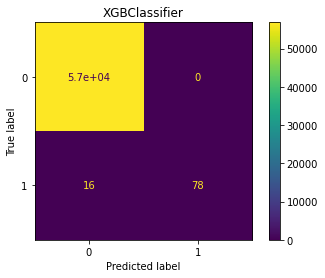

In [ ]:
xgboost_model_best = XGBClassifier(
    tree_method = "gpu_hist",
    random_state=RANDOM_STATE, 
    subsample=0.6,
    reg_lambda=1.5,
    n_estimators=600,
    max_depth=3,
    learning_rate=0.1,
    gamma=0.3,
    colsample_bytree=1.0
)
performance_xgboost_best = model_pipeline(X_train_xgboost, y_train, X_test_xgboost, y_test, xgboost_model_best)

In [ ]:
performance_xgboost_best

{'accuracy': 0.9997191109862715,
 'f1score': 0.9069767441860465,
 'fn': 16,
 'fp': 0,
 'fscore': 0.960591133004926,
 'jaccard': 0.8297872340425532,
 'model': 'XGBClassifier',
 'precision': array([0.00165022, 1.        , 1.        ]),
 'precision_recall_auc': 0.9150340615281408,
 'recall': array([1.        , 0.82978723, 0.        ]),
 'roc_auc': 0.9148936170212766,
 'threshold': array([0, 1]),
 'tn': 56868,
 'tp': 78}

### AutoML

In [ ]:
# AutoML pipeline
def automl_pipeline(X_train, y_train, X_test, y_test, sampler=None, time=30, metric=None):
    '''
    Building up automl pipelines with weighted classes
    
    X_train: training features with size (n_1,p)
    y_train: training labels with size (n_1,1)
    X_test: testing features with size (n_2, p)
    y_test: testing labels with size (n_2, p)
    
    sampler: sampling method, None by default
    
    return: dictionary of performance metrics
    '''
    if sampler:
        # resample X_train, y_train
        X_train, y_train = sampler.fit_sample(X_train, y_train)
        X_test, y_test = np.array(X_test), np.array(y_test)

    
    automl = autosklearn.classification.AutoSklearnClassifier(
        time_left_for_this_task=time,
        per_run_time_limit=int(time/10),
        #tmp_folder='/tmp/autosklearn_classification_example_tmp',
        #output_folder='/tmp/autosklearn_classification_example_out',
        metric='metric'
    )

    automl.fit(X_train, y_train)
    print(automl.show_models())
    predictions = automl.predict(X_test)

    accuracy = metrics.accuracy_score(y_test, predictions)
    precision, recall, threshold = metrics.precision_recall_curve(y_test, predictions)
    f1score = fbeta_score(y_test, predictions, beta=1.0)
    fscore = fbeta_score(y_test, predictions, beta=0.5)
    cm = metrics.confusion_matrix(y_test, predictions)
    tn, fp, fn, tp = cm.ravel()
    roc_auc = roc_auc_score(y_test, predictions)
    precision_recall_auc = auc(recall, precision)
    jaccard = jaccard_score(y_test, predictions)
            
    # plot_confusion matrix
    title = type(automl).__name__
    if sampler:
        title += type(sampler).__name__
    pyplt.figure(figsize=(6.4, 4.8))
    sns.heatmap(cm, annot=True, cmap='viridis')
    pyplt.xlabel('Predicted label')
    pyplt.ylabel('True label')
    pyplt.title(title)
    pyplt.show()
    
    performance = {'model':type(automl).__name__, 'accuracy': accuracy,
                   'precision': precision, 'recall': recall, 'threshold':threshold,
                   'f1score': f1score, 'fscore':fscore,
                   'tp': tp, 'tn': tn, 'fp': fp, 'fn': fn,
                   'roc_auc': roc_auc, 'precision_recall_auc': precision_recall_auc,
                   'jaccard': jaccard}
    return performance

#### Balanced Class Weight

[(0.200000, SimpleClassificationPipeline({'balancing:strategy': 'none', 'classifier:__choice__': 'random_forest', 'data_preprocessing:categorical_transformer:categorical_encoding:__choice__': 'one_hot_encoding', 'data_preprocessing:categorical_transformer:category_coalescence:__choice__': 'no_coalescense', 'data_preprocessing:numerical_transformer:imputation:strategy': 'mean', 'data_preprocessing:numerical_transformer:rescaling:__choice__': 'none', 'feature_preprocessor:__choice__': 'no_preprocessing', 'classifier:random_forest:bootstrap': 'True', 'classifier:random_forest:criterion': 'gini', 'classifier:random_forest:max_depth': 'None', 'classifier:random_forest:max_features': 0.5255991794296913, 'classifier:random_forest:max_leaf_nodes': 'None', 'classifier:random_forest:min_impurity_decrease': 0.0, 'classifier:random_forest:min_samples_leaf': 1, 'classifier:random_forest:min_samples_split': 2, 'classifier:random_forest:min_weight_fraction_leaf': 0.0},
dataset_properties={
  'task': 

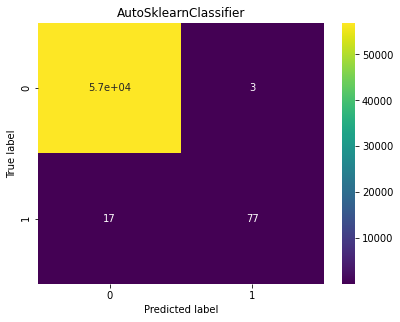

{'accuracy': 0.9996488887328394,
 'f1score': 0.8850574712643678,
 'fn': 17,
 'fp': 3,
 'fscore': 0.9299516908212561,
 'jaccard': 0.7938144329896907,
 'model': 'AutoSklearnClassifier',
 'precision': array([0.00165022, 0.9625    , 1.        ]),
 'precision_recall_auc': 0.8909736903736496,
 'recall': array([1.        , 0.81914894, 0.        ]),
 'roc_auc': 0.9095480912123484,
 'threshold': array([0, 1]),
 'tn': 56865,
 'tp': 77}

In [ ]:
performance_automl = automl_pipeline(X_train, y_train, X_test, y_test, 
                                     time=7200, metric=autosklearn.metrics.f1)
performance_automl

#### AutoML Under / Over / SMOTE Sampling

[(0.120000, SimpleClassificationPipeline({'balancing:strategy': 'none', 'classifier:__choice__': 'adaboost', 'data_preprocessing:categorical_transformer:categorical_encoding:__choice__': 'one_hot_encoding', 'data_preprocessing:categorical_transformer:category_coalescence:__choice__': 'no_coalescense', 'data_preprocessing:numerical_transformer:imputation:strategy': 'most_frequent', 'data_preprocessing:numerical_transformer:rescaling:__choice__': 'normalize', 'feature_preprocessor:__choice__': 'liblinear_svc_preprocessor', 'classifier:adaboost:algorithm': 'SAMME.R', 'classifier:adaboost:learning_rate': 0.01074809653055298, 'classifier:adaboost:max_depth': 6, 'classifier:adaboost:n_estimators': 491, 'feature_preprocessor:liblinear_svc_preprocessor:C': 320.73907979377447, 'feature_preprocessor:liblinear_svc_preprocessor:dual': 'False', 'feature_preprocessor:liblinear_svc_preprocessor:fit_intercept': 'True', 'feature_preprocessor:liblinear_svc_preprocessor:intercept_scaling': 1, 'feature_pr

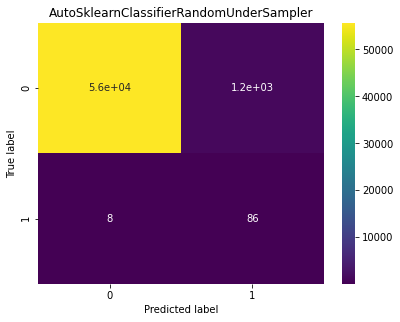

In [ ]:
performance_automl_under = automl_pipeline(X_train, y_train, X_test, y_test, sampler=under_sampler, time=1800)

In [ ]:
performance_automl_under

{'accuracy': 0.9788631017169341,
 'f1score': 0.125,
 'fn': 8,
 'fp': 1196,
 'fscore': 0.08234392952891612,
 'model': 'AutoSklearnClassifier',
 'precision': array([0.00165022, 0.06708268, 1.        ]),
 'precision_recall_auc': 0.4910583724177366,
 'recall': array([1.        , 0.91489362, 0.        ]),
 'roc_auc': 0.9469312285711293,
 'threshold': array([0, 1]),
 'tn': 55672,
 'tp': 86}

[(1.000000, SimpleClassificationPipeline({'balancing:strategy': 'none', 'classifier:__choice__': 'passive_aggressive', 'data_preprocessing:categorical_transformer:categorical_encoding:__choice__': 'one_hot_encoding', 'data_preprocessing:categorical_transformer:category_coalescence:__choice__': 'no_coalescense', 'data_preprocessing:numerical_transformer:imputation:strategy': 'mean', 'data_preprocessing:numerical_transformer:rescaling:__choice__': 'minmax', 'feature_preprocessor:__choice__': 'liblinear_svc_preprocessor', 'classifier:passive_aggressive:C': 7.491039171224502, 'classifier:passive_aggressive:average': 'True', 'classifier:passive_aggressive:fit_intercept': 'True', 'classifier:passive_aggressive:loss': 'squared_hinge', 'classifier:passive_aggressive:tol': 2.8058138048327884e-05, 'feature_preprocessor:liblinear_svc_preprocessor:C': 0.7754372809893839, 'feature_preprocessor:liblinear_svc_preprocessor:dual': 'False', 'feature_preprocessor:liblinear_svc_preprocessor:fit_intercept'

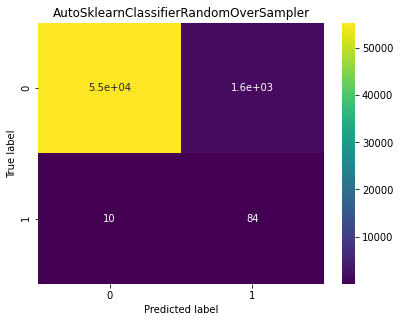

In [ ]:
performance_automl_over = automl_pipeline(X_train, y_train, X_test, y_test, sampler=over_sampler, time=1800)

In [ ]:
performance_automl_over

{'accuracy': 0.9721568765141674,
 'f1score': 0.09578107183580388,
 'fn': 10,
 'fp': 1576,
 'fscore': 0.06237006237006237,
 'model': 'AutoSklearnClassifier',
 'precision': array([0.00165022, 0.05060241, 1.        ]),
 'precision_recall_auc': 0.4721974932743651,
 'recall': array([1.        , 0.89361702, 0.        ]),
 'roc_auc': 0.9329518601494465,
 'threshold': array([0, 1]),
 'tn': 55292,
 'tp': 84}

[(1.000000, SimpleClassificationPipeline({'balancing:strategy': 'none', 'classifier:__choice__': 'passive_aggressive', 'data_preprocessing:categorical_transformer:categorical_encoding:__choice__': 'one_hot_encoding', 'data_preprocessing:categorical_transformer:category_coalescence:__choice__': 'no_coalescense', 'data_preprocessing:numerical_transformer:imputation:strategy': 'mean', 'data_preprocessing:numerical_transformer:rescaling:__choice__': 'minmax', 'feature_preprocessor:__choice__': 'liblinear_svc_preprocessor', 'classifier:passive_aggressive:C': 7.491039171224502, 'classifier:passive_aggressive:average': 'True', 'classifier:passive_aggressive:fit_intercept': 'True', 'classifier:passive_aggressive:loss': 'squared_hinge', 'classifier:passive_aggressive:tol': 2.8058138048327884e-05, 'feature_preprocessor:liblinear_svc_preprocessor:C': 0.7754372809893839, 'feature_preprocessor:liblinear_svc_preprocessor:dual': 'False', 'feature_preprocessor:liblinear_svc_preprocessor:fit_intercept'

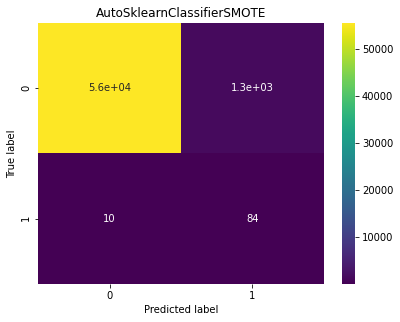

In [ ]:
performance_automl_smote = automl_pipeline(X_train, y_train, X_test, y_test, sampler=SMOTE_sampler, time=1800)

In [ ]:
performance_automl_smote

{'accuracy': 0.9766159896071065,
 'f1score': 0.11199999999999999,
 'fn': 10,
 'fp': 1322,
 'fscore': 0.07345225603357818,
 'model': 'AutoSklearnClassifier',
 'precision': array([0.00165022, 0.05974395, 1.        ]),
 'precision_recall_auc': 0.47676826569548625,
 'recall': array([1.        , 0.89361702, 0.        ]),
 'roc_auc': 0.9351851020429542,
 'threshold': array([0, 1]),
 'tn': 55546,
 'tp': 84}